# One-Class SVM with Enhanced Feature Spaces

## Imports

In [15]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit import BasicAer
from qiskit import Aer, transpile

from qiskit.utils import QuantumInstance
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit.library import ZFeatureMap
from qiskit.circuit.library import StatePreparation

from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.kernels import FidelityQuantumKernel

import qiskit_machine_learning.kernels
from qiskit.primitives import Sampler
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.datasets import ad_hoc_data


from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import r2_score, accuracy_score
from sklearn.model_selection import train_test_split
import random
from sklearn.datasets import make_blobs

import scipy.io
import pandas as pd
from qiskit.providers.aer import AerError
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit.algorithms.state_fidelities import ComputeUncompute
algorithm_globals.random_seed = 1
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from qiskit_machine_learning.circuit.library import RawFeatureVector

from qiskit.algorithms.linear_solvers.numpy_linear_solver import NumPyLinearSolver
from qiskit.algorithms.linear_solvers.hhl import HHL
from qiskit.quantum_info import DensityMatrix
from functools import reduce
from sympy import Matrix
from sympy import sqrt as special_sqrt
from qiskit import *
from qiskit.extensions import HamiltonianGate
from qiskit.quantum_info import Operator

dataset_list = []

## Code used to generate artificial datasets

Label 1 represents the inlier class, label -1 the outlier class.

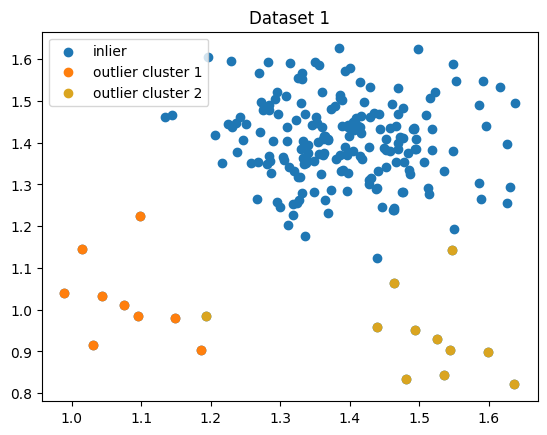

In [16]:
random.seed(13)
seed = 0
x, y = make_blobs(n_samples=190, centers=1, cluster_std=.1, center_box=(1.4, 1.4), random_state=seed)

out1x, out1y = make_blobs(n_samples=9, centers=1, cluster_std=.1, center_box=(1, 1), random_state=seed)
out2x, out2y = make_blobs(n_samples=11, centers=1, cluster_std=.1, center_box=(3.2, 0.01), random_state=seed)

plt.show()

# prepare data for One-Class model
y[y == 0] = 1
out1y[out1y==0] = -1 
out2y[out2y==0] = -1 

x = np.append(x, out1x, axis = 0)
y = np.append(y, out1y, axis = 0)

x = np.append(x, out2x, axis = 0)
y = np.append(y, out2y, axis = 0)

# Plot to see data
plt.scatter(x[:,0], x[:,1], label='inlier')
plt.scatter(out1x[:,0], out1x[:,1], label='outlier cluster 1')
plt.scatter(out2x[:,0], out2x[:,1], label='outlier cluster 2', color='goldenrod')

plt.title('Dataset 1')
plt.legend()
plt.show()

# Add data to dataset_list
dataset_list.append([x,y])

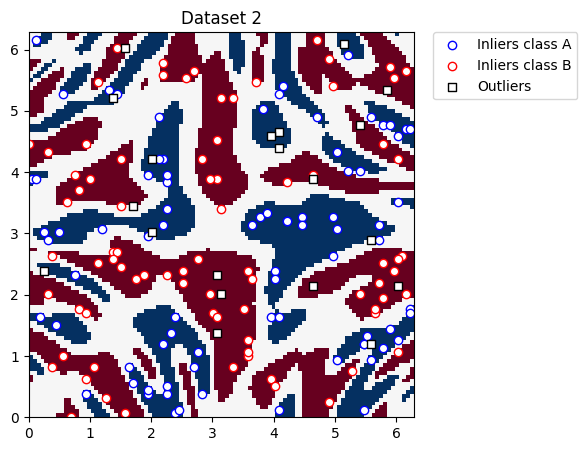

In [17]:
# Second dataset: ZZFeatureMap ad_hoc data
adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=80,
    test_size=0,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)
train_features_out, train_labels_out, _, _ = ad_hoc_data(
    training_size=10,
    test_size=0,
    n=adhoc_dimension,
    gap=0.6,
    plot_data=False,
    one_hot=False,
    include_sample_total=False,
)
# adhoc_total[adhoc_total == 0] = 1

# print(train_features)
# print(train_labels)

# Change labels for One-Class
train_labels_out[train_labels_out != -1] = -1

# Now we have to add the outliers
train_features = np.append(train_features, train_features_out, axis = 0)
train_labels = np.append(train_labels, train_labels_out, axis = 0)


plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap="RdBu",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
)

plt.scatter(
    train_features[np.where(train_labels[:] == 0), 0],
    train_features[np.where(train_labels[:] == 0), 1],
    marker="o",
    facecolors="w",
    edgecolors="b",
    label="Inliers class A",
)
plt.scatter(
    train_features[np.where(train_labels[:] == 1), 0],
    train_features[np.where(train_labels[:] == 1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="Inliers class B",
)
plt.scatter(
    train_features[np.where(train_labels[:] == -1), 0],
    train_features[np.where(train_labels[:] == -1), 1],
    marker="s",
    facecolors="w",
    edgecolors="k",
    label="Outliers",
)


plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Dataset 2")

plt.show()

# We don't need the second label for one-class SVMs, so change 0 label to 1
train_labels[train_labels == 0] = 1


# add data to dataset_list
dataset_list.append([train_features,train_labels])

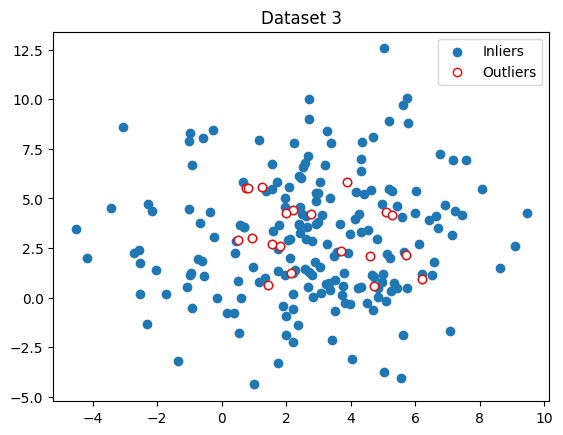

In [18]:
# Third dataset, create blob and add zz feature map data to it
random.seed(13)
seed = 23
x, y = make_blobs(n_samples=190, centers=1, cluster_std=3, center_box=(3, 3), random_state=seed)
train_features_out2, train_labels_out2, _, _ = ad_hoc_data(
    training_size=10,
    test_size=0,
    n=adhoc_dimension,
    gap=0.5,
    plot_data=False,
    one_hot=False,
    include_sample_total=False,
)

# prepare data for One-Class model
y[y == 0] = 1
train_labels_out2[train_labels_out2 != -1] = -1 

# add outliers to data
x = np.append(x, train_features_out2, axis = 0)
y = np.append(y, train_labels_out2, axis = 0)

# Plot to see data
plt.scatter(x[:,0], x[:,1], label='Inliers')
plt.scatter(
    train_features_out2[np.where(train_labels_out2[:] == -1), 0],
    train_features_out2[np.where(train_labels_out2[:] == -1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="Outliers",
)

plt.title('Dataset 3')
plt.legend()
plt.show()

# Add data to dataset_list
dataset_list.append([x,y])

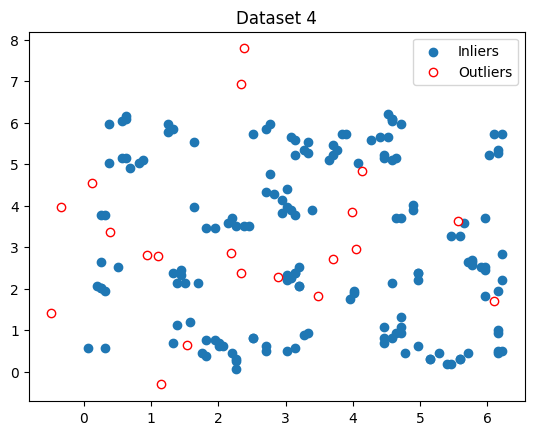

In [19]:
adhoc_dimension = 2
train_features, train_labels, _,_ = ad_hoc_data(
    training_size=80,
    test_size=0,
    n=adhoc_dimension,
    gap=0.6,
    plot_data=False,
    one_hot=False,
    include_sample_total=False,
)
x, y = make_blobs(n_samples=20, centers=3, cluster_std=2, center_box=(3, 3), random_state=111)

# prepare data for One-Class model
train_labels[train_labels == 0] = 1
y[y != -1] = -1 

# add outliers to data
train_features = np.append(train_features, x, axis = 0)
train_labels = np.append(train_labels, y, axis = 0)

# Plot to see data
plt.scatter(
    train_features[np.where(train_labels[:] == 1), 0],
    train_features[np.where(train_labels[:] == 1), 1],
    #marker="o",
    #facecolors="w",
    #edgecolors="b",
    label="Inliers",
)
plt.scatter(
    x[np.where(y[:] == -1), 0],
    x[np.where(y[:] == -1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="Outliers"
)

plt.title('Dataset 4')
plt.legend()
plt.show()

# Add data to dataset_list
dataset_list.append([train_features,train_labels])

### Save/Load data

In [20]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
def load_object(filename):
    with open(filename, 'rb') as fileload:
        file = pickle.load(fileload)
    return file
# save_object(dataset_list, "datasets_small")
dataset_list = load_object("datasets")

## Custom Feature Maps

In [21]:
def custom_data_map_func(x):
    mapped = x[0] if len(x) == 1 else reduce(lambda m, n: m * n, x)
    return mapped
def feature_map_superfidel(x):
    # as described in 
    # https://doi.org/10.1103/PhysRevA.97.042315
    
    # Qiskit currently doesn't natively support a square root function in a parameter expression
    # So use sympy base to get the same effect
    mapped = x[0] if len(x) == 1 else reduce(lambda m, n: m * n, 
                                             np.divide(x,(1-np.square(np.column_stack(x)).trace())._call(special_sqrt)))
    if len(x) != 1:
        print(1-np.square(np.column_stack(x)).trace())
    return mapped

## Quantum Function for OneClass (Algorithm 1)

In [22]:
# First algorithm, returns trained model
def Algorithm1(X, y, reps=2, shots=1, outliers_fraction=20/210,
               entanglement="linear", num_features = 2, seed = 0, 
               supervised=False, feature_map_no = 1, data_map_no = 1, paulis = ["Z", "ZZ"]) :
    if feature_map_no == 1:
        # Define ZZFeatureMap using inputs
        if data_map_no == 1:
             feature_map = ZZFeatureMap(feature_dimension = num_features, 
                                   reps = reps, entanglement=entanglement)
        elif data_map_no == 2:
            feature_map = ZZFeatureMap(feature_dimension = num_features, 
                                   reps = reps, entanglement=entanglement, 
                                       data_map_func = custom_data_map_func)
        elif data_map_no == 3:
            feature_map = ZZFeatureMap(feature_dimension = num_features, 
                                   reps = reps, entanglement=entanglement, 
                                       data_map_func = feature_map_superfidel)
    elif feature_map_no == 2:
        # Define ZZFeatureMap using inputs
        feature_map = ZFeatureMap(feature_dimension = num_features, reps = reps)
    elif feature_map_no == 3:
        # Define ZZFeatureMap using inputs
        feature_map = PauliFeatureMap(feature_dimension = num_features, reps = reps, paulis=paulis)
    # Calculates probabilities of bit results from quantum circuits
    sampler = Sampler()
    # uses sampler to calculate state fidelity of 2 quantum circuits
    fidelity = ComputeUncompute(sampler=sampler)
    # Translates data with base state fidelity distance metric
    kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)
    # Kernel needs to be evaluated before going into the One-Class SVM
    svm = OneClassSVM(kernel = kernel.evaluate, verbose=True, nu=outliers_fraction)
    if supervised: 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=seed)
        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)
        print("Macro F1: {}".format(f1_score(y, y_pred, average='macro')))

    else: 
        svm.fit(X)
        y_pred = svm.predict(X)
        print("Macro 1: {}".format(f1_score(y, y_pred, average='macro')))

    return svm

## Showcase of Algorithm 1

In [ ]:
dataset_count = 0
outliers_fraction=20/210
entanglement_list = ["full", 'linear']
data_map_list = []
for X, y in dataset_list:
    dataset_count = dataset_count + 1
    print()
    print("For dataset: {}".format(dataset_count))
    print()
    Algorithm1(X, y, reps=4)
    print()
    print("For dataset: {}".format(dataset_count))
    print()
    print("Experiment with number of repetitions 1,2,3")
    for i in range(1,4):
        print("For reps: {}".format(i))
        Algorithm1(X, y, reps=i)
    print()
    print("Experiment with different Feature maps")
    for i in range(1,4):
        print("For feature_map: {}".format(i))
        Algorithm1(X, y, feature_map_no=i)
    print()
    print("Experiment with different entanglements")
    for i in entanglement_list:
        print("For entanglement: {}".format(i))
        Algorithm1(X, y, entanglement=i)
    print()
    print("Experiment with different data_maps")
    for i in range(1,4):
        print("For data_map: {}".format(i))
        Algorithm1(X, y, data_map_no=i)
    print()
    print("Experiment with different shots")
    for i in range(1,5,2):
        print("For shots: {}".format(i))
        Algorithm1(X, y, shots=i)

### Experiment with different Pauli Matrices

In [ ]:
Pmatrices = ["X", "Y", "Z"]
paulis_list = []
def combp(pm, prefix, n, k, fullermatrix):
    if (k == 0) :
        fullermatrix.append(prefix)
        return fullermatrix
    for i in range(n):
        newPrefix = prefix + pm[i]
        combp(pm, newPrefix, n, k - 1, fullermatrix)
    return fullermatrix
paulis_list = combp(Pmatrices,"",len(Pmatrices),2,paulis_list)
secondpaulis_list = []
for e in paulis_list:
    for i in Pmatrices:
        secondpaulis_list.append([i,e])
secondpaulis_list.append(["I", "II"])



# Experiment with Pauli Matrices
for X, y in dataset_list:
    dataset_count = dataset_count + 1
    print()
    print("For dataset: {}".format(dataset_count))
    print()
    for m in secondpaulis_list:
        print("For pauli matrix: {}".format(m))
        Algorithm1(X, y, feature_map_no=3, paulis=m)

### Comparison to other One-Class SVM methods

In [26]:
other_kernel_list = ['rbf', 'linear', 'poly', 'sigmoid']
outliers_fraction=20/210
dataset_count = 0
supervised = False
for X,y in dataset_list:
    dataset_count = dataset_count + 1
    print()
    print("For dataset: {}".format(dataset_count))
    for kernel in other_kernel_list:
        svm_classical = OneClassSVM(kernel = kernel, verbose=True,  nu=outliers_fraction)
        if supervised:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
            svm_classical.fit(X_train, y_train)
            y_pred = svm_classical.predict(X_test)
            # TODO save to Matrix
            print("{}: ".format(kernel))
            print("Macro F1: {}".format(f1_score(y_test, y_pred, average='macro')))
            
            print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

            print("Precision 1: {}".format(precision_score(y_test, y_pred, average='binary')))
            print("Precision -1: {}".format(precision_score(y_test, y_pred, pos_label=-1, average='binary')))
            
            print("Macro Recall: {}".format(recall_score(y_test, y_pred, average='macro')))
            
#             print("Recall 1: {}".format(recall_score(y_test, y_pred, average='binary')))
#             print("Recall -1: {}".format(recall_score(y_test, y_pred, pos_label=-1, average='binary')))
            
#             print("F1 1: {}".format(f1_score(y_test, y_pred, average='binary')))
#             print("F1 -1: {}".format(f1_score(y_test, y_pred, pos_label=-1, average='binary')))

        else:
            svm_classical.fit(X)
            y_pred = svm_classical.predict(X)
            # TODO save to Matrix

            print("{}: ".format(kernel))
            print("Macro F1: {}".format(f1_score(y, y_pred, average='macro')))

            print("Accuracy: {}".format(accuracy_score(y, y_pred)))
            
            print("Precision 1: {}".format(precision_score(y, y_pred, average='binary')))
            print("Precision -1: {}".format(precision_score(y, y_pred, pos_label=-1, average='binary')))
            
            print("Macro Recall: {}".format(recall_score(y, y_pred, average='macro')))
            
#             print("Recall 1: {}".format(recall_score(y, y_pred, average='binary')))
#             print("Recall -1: {}".format(recall_score(y, y_pred, pos_label=-1, average='binary')))
            
#             print("F1 1: {}".format(f1_score(y, y_pred, average='binary')))
#             print("F1 -1: {}".format(f1_score(y, y_pred, pos_label=-1, average='binary')))




For dataset: 1
[LibSVM]*
optimization finished, #iter = 98
obj = 28.399995, rho = 2.922003
nSV = 27, nBSV = 12
rbf: 
Macro F1: 0.6749444780940843
Accuracy: 0.8904761904761904
Precision 1: 0.93717277486911
Precision -1: 0.42105263157894735
Macro Recall: 0.6710526315789473
[LibSVM]*
optimization finished, #iter = 25
obj = 525.982649, rho = 58.131565
nSV = 21, nBSV = 19
linear: 
Macro F1: 0.9171052631578946
Accuracy: 0.9714285714285714
Precision 1: 0.9842105263157894
Precision -1: 0.85
Macro Recall: 0.9171052631578946
[LibSVM]*
optimization finished, #iter = 28
obj = 61178403.116152, rho = 8072235.195419
nSV = 21, nBSV = 19
poly: 
Macro F1: 0.9171052631578946
Accuracy: 0.9714285714285714
Precision 1: 0.9842105263157894
Precision -1: 0.85
Macro Recall: 0.9171052631578946
[LibSVM]*
optimization finished, #iter = 0
obj = 200.000000, rho = 20.000000
nSV = 20, nBSV = 19
sigmoid: 
Macro F1: 0.08695652173913042
Accuracy: 0.09523809523809523
Precision 1: 0.0
Precision -1: 0.09523809523809523
Mac

/home/alex/um/project/quantum-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Algorithm attempt for Nana Liu paper for Quantum SVMs

In [27]:

def K(x,z, p_constant=1.0):
    return (np.dot(x.T,z)+p_constant)**2

def Algorithm2(X, y, reps=1, shots=1, outliers_fraction=1/4,entanglement="linear", num_features = 2, seed = 0, supervised=False):
    # Qiskit code for RawFeatureVector has bug, currently not in use
    # TODO We should use RawFeatureVector to stay true to the paper, but Qiskit currently has problem with this method
#     feature_map = RawFeatureVector(feature_dimension = num_features)
#     print(feature_map.parameters)
#     par0 = feature_map.parameters[0]
#     par1 = feature_map.parameters[1]
#     print(par0)
#     print(par1)
#     state = np.array([1, 1]) / np.sqrt(2)
#     feature_map = feature_map.assign_parameters(state)
#     theta_range = np.linspace(0, 2 * np.pi, 128)
#     print(feature_map.parameters)
#     feature_map = feature_map.bind_parameters({par0: 1/np.sqrt(2), par1: 1/np.sqrt(2)})
#     feature_map = ZZFeatureMap(feature_dimension = num_features, reps = reps, entanglement=entanglement)
#     feature_map = ZFeatureMap(feature_dimension = num_features, reps = reps)
#     feature_map = PauliFeatureMap(feature_dimension = num_features, reps = reps)

#     # Calculates probabilities of bit results from quantum circuits
#     sampler = Sampler()
#     # uses sampler to calculate state fidelity of 2 quantum circuits
#     fidelity = ComputeUncompute(sampler=sampler)
#     # Translates data with base state fidelity distance metric
#     kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)
#     # Kernel needs to be evaluated before going into the One-Class SVM

#     # Algorithm 2 starts here 
#     svm = OneClassSVM(kernel = kernel.evaluate, verbose=True, nu=outliers_fraction)
# #     classical_solution = NumPyLinearSolver().solve(X, y / np.linalg.norm(y))

    # Trick to make matrix hermitian
#     X = np.matrix(X)
#     Xh = X.getH()
#     zeroes1 = np.zeros((X.shape[0], X.shape[0]))
#     zeroes2 = np.zeros((X.shape[1], X.shape[1]))
    
#     X = np.bmat([[zeroes1, X], [Xh, zeroes2]])
#     y = np.append(y, [1,1])
#     X = DensityMatrix(X)
#     np.real(X)
#     print(X)
#     hhl = HHL()
#     hhl.construct_circuit(X,y)
#     inversed_matrix = hhl.solve(X,y)
#     X = X[:128]
#     y = y[:128]
    # Calculate Kernel Matrix
    K = np.dot(X, np.transpose(X))
    
    # Change Kernel Matrix to density matrix gram
    K_ = np.divide(K, K.trace())
    
    # density matrix exponentiation technique
    # First make matrix hermitian
    K_ = np.matrix(K_)
    K_h = K_.getH()
    zeroes1 = np.zeros((K_.shape[0], K_.shape[0]))
    zeroes2 = np.zeros((K_.shape[1], K_.shape[1]))
    
    hermitian_K = np.bmat([[zeroes1, K_], [K_h, zeroes2]])
    
   
#     y = np.append(y, [1,1])
    
    
#     K_dense = DensityMatrix(K_)
#     K_q = Operator(K_)
#     print(K_q)
#     K_q = K_q.to_instruction()
#     h = HamiltonianGate(hermitian_K, 1)
#     print(len(K_))
#     print(len(X))
    
    zeroesy = np.zeros(len(hermitian_K)-len(y))
    new_y = np.append(y,zeroesy)
    # invert Kernel Matrix
    sim_mps = Aer.get_backend('aer_simulator_matrix_product_state')
    classical_solution = NumPyLinearSolver().solve(hermitian_K, new_y / np.linalg.norm(new_y))
    print(classical_solution)
    return
    hhl = HHL(epsilon=1, quantum_instance=sim_mps)
    circuit_hhl = hhl.construct_circuit(hermitian_K,new_y, neg_vals=False)
#     hhl0 =  transpile(hhl, backend=sim_mps, seed_transpiler=11, optimization_level=0)
#     hhl1 =  transpile(hhl, backend=sim_mps, seed_transpiler=11, optimization_level=1)
#     hhl2 =  transpile(hhl, backend=sim_mps, seed_transpiler=11, optimization_level=2)
#     hhl3 =  transpile(hhl, backend=sim_mps, seed_transpiler=11, optimization_level=3)
    print(circuit_hhl.decompose())
    print(hhl0.decompose())
    print(hhl1.decompose())
    print(hhl2.decompose())
    print(hhl3.decompose())

#     inversed_matrix = hhl.solve(hermitian_K,new_y)
    print(inversed_matrix)
    print(inversed_matrix.observable)
    return
    # Test with custom feature map
    feature_map = PauliFeatureMap(feature_dimension=2, reps=reps, data_map_func=feature_map_superfidel)
    # Calculates probabilities of bit results from quantum circuits
    sampler = Sampler()
    # uses sampler to calculate state fidelity of 2 quantum circuits
    fidelity = ComputeUncompute(sampler=sampler)
    # Translates data with base state fidelity distance metric
    kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)
    svm = OneClassSVM(kernel = kernel.evaluate, verbose=True, nu=outliers_fraction)

    if supervised: 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=seed)
        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)
        # TODO save to Matrix
#         print(classification_report(y_test, y_pred))
        print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

        print("Precision 1: {}".format(precision_score(y_test, y_pred, average='binary')))
        print("Precision -1: {}".format(precision_score(y_test, y_pred, pos_label=-1, average='binary')))

        print("Recall 1: {}".format(recall_score(y_test, y_pred, average='binary')))
        print("Recall -1: {}".format(recall_score(y_test, y_pred, pos_label=-1, average='binary')))

        print("F1 1: {}".format(f1_score(y_test, y_pred, average='binary')))
        print("F1 -1: {}".format(f1_score(y_test, y_pred, pos_label=-1, average='binary')))
    else: 
        svm.fit(X)
        y_pred = svm.predict(X)
        #TODO save to matrix
#         print(classification_report(y, y_pred))
        print("Accuracy: {}".format(accuracy_score(y, y_pred)))

        print("Precision 1: {}".format(precision_score(y, y_pred, average='binary')))
        print("Precision -1: {}".format(precision_score(y, y_pred, pos_label=-1, average='binary')))

        print("Recall 1: {}".format(recall_score(y, y_pred, average='binary')))
        print("Recall -1: {}".format(recall_score(y, y_pred, pos_label=-1, average='binary')))

        print("F1 1: {}".format(f1_score(y, y_pred, average='binary')))
        print("F1 -1: {}".format(f1_score(y, y_pred, pos_label=-1, average='binary')))
        
    return svm

In [15]:
dataset_count = 0
outliers_fraction=1/4
# MAKE SMALL DATASET
for X, y in dataset_list:
    dataset_count = dataset_count + 1
    print("For dataset: {}".format(dataset_count))
    for i in range(2,3):
        print("For reps: {}".format(i))
        Algorithm2(X, y, i, 1, outliers_fraction=outliers_fraction)

For dataset: 1
For reps: 2
{   'circuit_results': None,
    'euclidean_norm': 5.208533804241974e+16,
    'observable': None,
    'state': array([ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        1.64626730e+16, -2.50993237e+15,  2.85064745e+16, -4.02857790e+16])}


C:\Users\slang\AppData\Local\Temp/ipykernel_8420/1911906896.py:81: DeprecationWarning: The NumPyLinearSolver class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  classical_solution = NumPyLinearSolver().solve(hermitian_K, new_y / np.linalg.norm(new_y))


# Quantum Auto Encoder Implementation in Qiskit
Inspired from https://arxiv.org/abs/2210.02674

In [38]:
from qiskit.circuit import QuantumCircuit, Parameter
from itertools import combinations
from qibo import hamiltonians
from qiskit.opflow import Z, I, StateFn, CircuitStateFn, SummedOp
from qiskit.opflow import X as X_gate
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector, ParameterExpression
from qiskit.circuit.library import EfficientSU2

def Quantum_Autoencoder_circuit(parameters, num_qubits, num_trash_qubits, layers, num_parameters):
    circuit = QuantumCircuit(num_qubits)
    paramidx = 0
    if (num_trash_qubits <= num_qubits/2):
        for l in range(layers):
            for idx in range(num_trash_qubits):
                for q in range(num_qubits):
                    #phase rotation
                    temp_parameter = Parameter('{}'.format(paramidx))
                    circuit.ry(temp_parameter,q)
                    circuit.assign_parameters({temp_parameter: parameters[q+idx*num_qubits+l*num_trash_qubits*num_qubits]})
                    paramidx += 1
                # CZ between trash qubits
                for i,j in combinations(range(num_qubits-num_trash_qubits,num_qubits),2):
                    circuit.cz(i,j)
                # CZ between trash and non-trash qubits
                for i in range(num_trash_qubits):
                    for j in range(i,num_qubits-num_trash_qubits,num_trash_qubits):
                        circuit.cz(num_qubits-num_trash_qubits+((idx+i)%num_trash_qubits),j)
    else :
        for l in range(layers):
            for idx in range(num_qubits-num_trash_qubits):
                for q in range(num_qubits):
                    #phase rotation
                    temp_parameter = Parameter('{}'.format(paramidx))
                    circuit.ry(temp_parameter,q)
#                     circuit.ry(parameters[q+idx*num_qubits+l*(num_qubits-num_trash_qubits)*num_qubits],q)
                    circuit.assign_parameters({temp_parameter: parameters[q+idx*num_qubits+l*(num_qubits-num_trash_qubits)*num_qubits]})
                    paramidx += 1
                # CZ between trash qubits
                for i,j in combinations(range(num_qubits-num_trash_qubits,num_qubits),2):
                    circuit.cz(i,j)
                for i in range(num_qubits-num_trash_qubits):
                    for j in range(num_qubits-num_trash_qubits+i,num_qubits,num_qubits-num_trash_qubits):
                        circuit.cz((idx+i)%(num_qubits-num_trash_qubits),j)
    for q in range(num_trash_qubits):
        temp_parameter = Parameter('{}'.format(paramidx))
        circuit.ry(temp_parameter,q)
#         circuit.ry(parameters[num_parameters-num_trash_qubits+q], num_qubits-num_trash_qubits+q)
        circuit.assign_parameters({temp_parameter: parameters[num_parameters-num_trash_qubits+q]})
        paramidx += 1
    
    return circuit

#TODO
def cost_hamiltonian(num_qubits, num_trash_qubits, outliers_fraction = 20/210):
    
    num_trash_qubits = num_trash_qubits 
#     print(num_trash_qubits)
#     print(hamiltonians.Z(num_trash_qubits))
#     print(hamiltonians.Z(num_trash_qubits).matrix)
#    print(hamiltonians.Z(num_trash_qubits).matrix)
#    print(type(hamiltonians.Z(num_trash_qubits).matrix))

    m0 = hamiltonians.Z(num_trash_qubits).matrix#.numpy()
    m1 = np.eye(2 ** (num_qubits - num_trash_qubits), dtype=m0.dtype)
    ham = hamiltonians.Hamiltonian(num_qubits, np.kron(m1, m0))

    return 0.5 * (ham + num_trash_qubits)

def data_encoding(X, encoding):
    encoded_X = []
    
    
    
    print(encoding)
    if encoding == "Amplitude":
        num_qubits = 2
        for i in range(len(X)):
            encoded_X.append(np.array(X[i])/np.linalg.norm(np.array(X[i])))
    elif encoding == "FRQI":
        num_qubits = 2
        for i in range(len(X)):
            vector = np.concatenate((np.cos(np.pi/2*np.array(X[i])),np.sin(np.pi/2*np.array(X[i]))))/8.0
            encoded_X.append(vector/np.linalg.norm(np.array(vector)))  
    else:
        raise ValueError(
            "Not a valid encoding"
        )
    
    
    return encoded_X, num_qubits


In [46]:
import torch.optim as optim
import torch
from geneticalgorithm import geneticalgorithm as ga
class VQOCC(): 
    def __init__(self, num_qubits, num_trash_qubits, layers):

        assert num_trash_qubits < num_qubits

        self.num_qubits = num_qubits
        self.num_trash_qubits = num_trash_qubits
        self.layers = layers

        if (num_trash_qubits <= num_qubits/2):
            num_parameters = num_trash_qubits * (num_qubits * layers + 1)
        else:
            num_parameters = (num_qubits-num_trash_qubits)*num_qubits*layers + num_trash_qubits

        self.num_parameters = num_parameters
        self.parameters = np.random.uniform(low=0.0, high=1.0, size=(num_parameters,))
        self.circuit = Quantum_Autoencoder_circuit(self.parameters, num_qubits, num_trash_qubits, layers, num_parameters)
     
    def function(self, parameters):
        circuit_copy = self.circuit.copy()

        circuit_copy.assign_parameters(parameters, inplace=True)

    #             print(parameters)
        batch_index = np.random.randint(0, len(self.X), (self.batch_size,))
        vector_batch = [self.X[i] for i in batch_index]
        temp_loss = 0
        for i in range(self.batch_size):
    #                 circuit_copy = circuit.copy()
    #             for i in range(len(X)-1):
            start_qc = QuantumCircuit(2)
            #start_qc.initialize(self.X[i], start_qc.qubits[0])
            #start_qc.initialize(self.X[i], start_qc.qubits[1])
            start_qc.initialize(self.X[i])
    
            qc = start_qc + circuit_copy
            qc.save_statevector('test1')
            qc.measure_all()
            qc.save_statevector('test2')

            sim = Aer.get_backend('aer_simulator')
            qobj = assemble(qc)
            job = sim.run(qobj,shots=100)
            result = job.result()
            data = result.data()
            resulting_state = data['test2'].data
            temp_loss += self.ham.expectation(resulting_state)/(self.num_trash_qubits*self.batch_size)
        return temp_loss
    def train(self,X,lr=0.1,n_epochs=150,batch_size=10,verbose_loss=False):



        parameters = self.parameters
        best_parameters = self.parameters
        loss_history = []
        num_trash_qubits = self.num_trash_qubits
        self.batch_size = batch_size
        circuit = self.circuit.copy()
        self.X = X
        self.ham = cost_hamiltonian(self.num_qubits,num_trash_qubits)
#         print(type(ham))
        loss = 1
    # ATTEMPTED GRADIENT DESCENT, WASN'T ABLE TO WORK DUE TO GRADIENT CALCULATION OF QUANTUM CIRCUIT IN QISKIT DOESNT SEEM TO BE POSSIBLE
    
#         for e in range(n_epochs):
#             # Training Quantum circuit with loss functions evaluated from Hamiltonian
#             # using automatic differentiation
# #             print(len(parameters))
#             circuit_copy = circuit.copy()
    
# #             circuit_copy.assign_parameters(parameter_tensor[0].detach().numpy(), inplace=True)
#             circuit_copy.assign_parameters(parameters, inplace=True)

# #             print(parameters)
#             batch_index = np.random.randint(0, len(X), (batch_size,))
#             vector_batch = [X[i] for i in batch_index]
#             temp_loss = 0
#             for i in range(batch_size):
# #                 circuit_copy = circuit.copy()
# #             for i in range(len(X)-1):
#                 start_qc = QuantumCircuit(2)
#                 start_qc.initialize(encoded_X[i], start_qc.qubits[0])
#                 start_qc.initialize(encoded_X[i], start_qc.qubits[1])
#                 qc = start_qc + circuit_copy
#                 qc.save_statevector('test1')
#                 qc.measure_all()
#                 qc.save_statevector('test2')

#                 sim = Aer.get_backend('aer_simulator')
#                 qobj = assemble(qc)
#                 job = sim.run(qobj,shots=1024)
#                 result = job.result()
#                 data = result.data()
#                 resulting_state = data['test1'].data
#                 temp_loss += self.ham.expectation(resulting_state)/(num_trash_qubits*batch_size)
            
# #             optimizer.zero_grad()
# #             loss = torch.tensor(temp_loss.numpy(), requires_grad=True)
# #             loss.backward()
# #             print(parameter_tensor[0].grad)

#             if temp_loss < loss:
#                 loss = temp_loss
#                 best_parameters = parameters
#             else:
#                 parameters = np.random.uniform(low=0.0, high=1.0, size=(len(parameters),))
# #             loss = temp_loss
#             print(loss)
#             #TODO Calculate loss/parameter gradients
            
#             #TODO Apply gradients to parameters, and update them
# #             print(optimizer)
            
#             loss_history.append(loss)
            
            
        
            
        varbound1 = [0.0,1.0]
        vartype1 = ['real']
        varbound = []
        vartype = []
        for i in range(len(parameters)):
            varbound.append(varbound1)
            vartype.append(vartype1)
        varbound = np.array(varbound)
        vartype = np.array( vartype)
#         varbound = np.full(shape=len(parameters),fill_value=varbound1)
#         print(varbound)
#         print(varbound1 for i in range(len(parameters)))
        
        
#         vartype=np.array([['real'],['int'],['int']])
        algorithm_param = {'max_num_iteration': n_epochs,\
                           'population_size':100,\
                           'mutation_probability':0.1,\
                           'elit_ratio': 0.1,\
                           'crossover_probability': 0.5,\
                           'parents_portion': 0.3,\
                           'crossover_type':'uniform',\
                           'max_iteration_without_improv':None}
        model=ga(function=self.function,dimension=len(parameters),variable_type_mixed=vartype,
                 variable_boundaries=varbound, algorithm_parameters = algorithm_param)
        model.run()
        self.parameters = model.output_dict['variable']
        
        if verbose_loss == True :
            return loss_history
    def test(self,X, y):
        circuit_copy = self.circuit.copy()
        circuit_copy.assign_parameters(self.parameters, inplace=True)
        batch_index = np.random.randint(0, len(X), (self.batch_size,))
        vector_batch = [X[i] for i in batch_index]
        temp_loss = 0
        

        y_pred = []
        for i in range(len(X)):
            start_qc = QuantumCircuit(2)
            #start_qc.initialize(X[i], start_qc.qubits[0])
            #start_qc.initialize(X[i], start_qc.qubits[1])
            start_qc.initialize(X[i])

            qc = start_qc + circuit_copy
            qc.save_statevector('test1')
            qc.measure_all()
            qc.save_statevector('test2')

            sim = Aer.get_backend('aer_simulator')
            qobj = assemble(qc)
            job = sim.run(qobj,shots=100)
            result = job.result()
            data = result.data()
            resulting_state = data['test2'].data
            temp = self.ham.expectation(resulting_state)/self.num_trash_qubits
            y_pred.append(temp)#.numpy())
#             print(resulting_state)
#             if y[i] == 1:
#                 inliers.append(resulting_state)
#             else:
#                 outliers.append(resulting_state)
# #             temp_loss += self.ham.expectation(resulting_state)/(self.num_trash_qubits*self.batch_size)
# #         print(inliers)
# #         print(outliers)
#         for i in range(len(inliers)):
#             if 
        y_pred = np.around(y_pred)
        y_pred[y_pred == 0] = -1
#         print(y_pred)
        print("Accuracy: {}".format(accuracy_score(y, y_pred)))

        print("Precision 1: {}".format(precision_score(y, y_pred, average='binary')))
        print("Precision -1: {}".format(precision_score(y, y_pred, pos_label=-1, average='binary')))
        
        print("Recall 1: {}".format(recall_score(y, y_pred, average='macro')))
        print("Macro F1: {}".format(f1_score(y, y_pred, average='macro')))

#         print("Recall 1: {}".format(recall_score(y, y_pred, average='binary')))
#         print("Recall -1: {}".format(recall_score(y, y_pred, pos_label=-1, average='binary')))

        print("F1 1: {}".format(f1_score(y, y_pred, average='binary')))
        print("F1 -1: {}".format(f1_score(y, y_pred, pos_label=-1, average='binary')))

For dataset: 1
For number of layers: 2
FRQI


/tmp/ipykernel_26861/1717457995.py:39: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = start_qc + circuit_copy


 The best solution found:                                                                           
 [0.02387069 0.01026153 0.41246199 0.81013974 0.25724297]

 Objective function:
 0.0


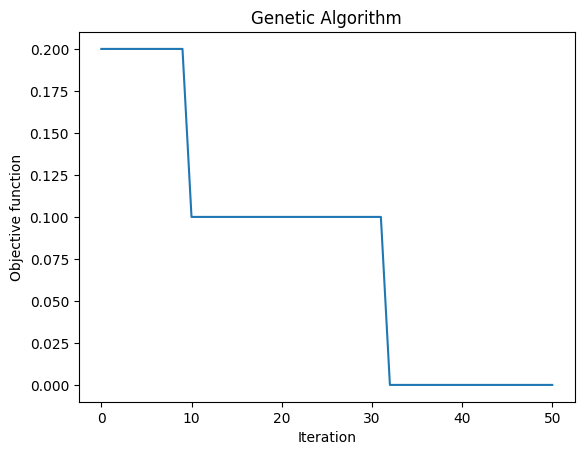

/tmp/ipykernel_26861/1717457995.py:167: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = start_qc + circuit_copy


Accuracy: 0.5238095238095238
Precision 1: 0.9166666666666666
Precision -1: 0.10784313725490197
Recall 1: 0.5355263157894736
Macro F1: 0.4223786995269006
F1 1: 0.6644295302013422
F1 -1: 0.180327868852459
For number of layers: 4
FRQI


/tmp/ipykernel_26861/1717457995.py:39: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = start_qc + circuit_copy


 The best solution found:                                                                           
 [0.77536476 0.85887678 0.79828775 0.46619398 0.96655277 0.80199249
 0.94277649 0.17875307 0.87334384]

 Objective function:
 0.0


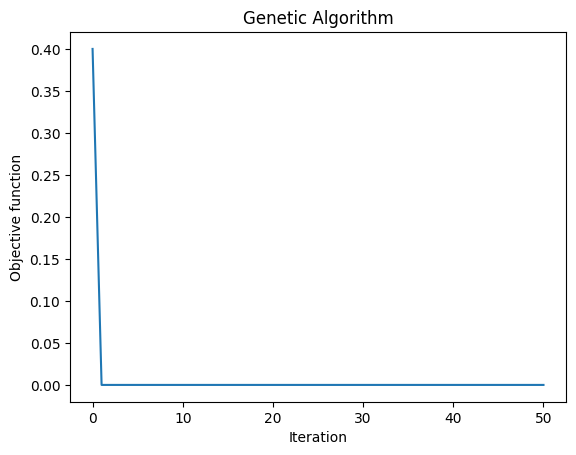

/tmp/ipykernel_26861/1717457995.py:167: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = start_qc + circuit_copy


Accuracy: 0.2857142857142857
Precision 1: 0.7941176470588235
Precision -1: 0.04225352112676056
Recall 1: 0.29210526315789476
Macro F1: 0.2463393626184324
F1 1: 0.4186046511627907
F1 -1: 0.07407407407407407
For number of layers: 6
FRQI


/tmp/ipykernel_26861/1717457995.py:39: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = start_qc + circuit_copy


 The best solution found:                                                                           
 [0.05780377 0.89363165 0.72743099 0.85679027 0.11331638 0.70392326
 0.08639105 0.9799175  0.03870155 0.71996991 0.08634225 0.55150579
 0.37051288]

 Objective function:
 0.0


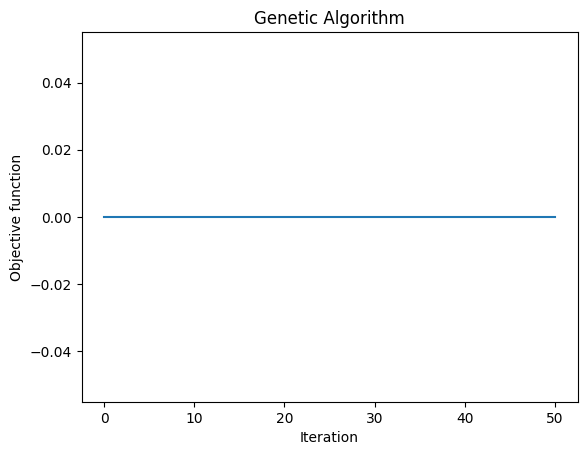

/tmp/ipykernel_26861/1717457995.py:167: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = start_qc + circuit_copy


Accuracy: 0.3
Precision 1: 0.8028169014084507
Precision -1: 0.04316546762589928
Recall 1: 0.3
Macro F1: 0.2561266536543049
F1 1: 0.43678160919540227
F1 -1: 0.07547169811320754
For number of layers: 8
FRQI


/tmp/ipykernel_26861/1717457995.py:39: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = start_qc + circuit_copy


 The best solution found:                                                                           
 [0.51854411 0.98035909 0.29954679 0.10711875 0.52711393 0.63156735
 0.63255572 0.66178902 0.20408908 0.54209429 0.24326926 0.81329119
 0.25364751 0.48763095 0.45426387 0.77394126 0.83483322]

 Objective function:
 0.0


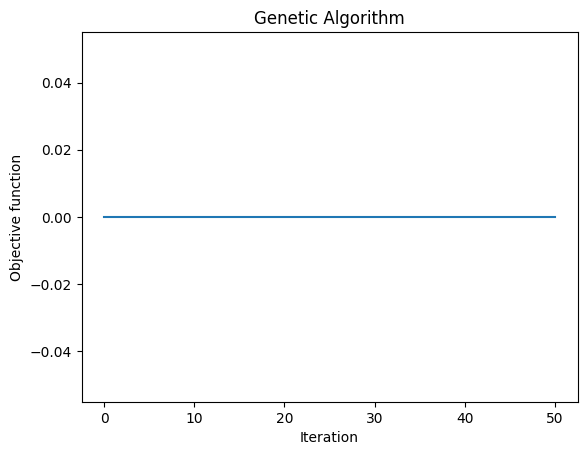

/tmp/ipykernel_26861/1717457995.py:167: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = start_qc + circuit_copy


Accuracy: 0.19047619047619047
Precision 1: 0.8125
Precision -1: 0.07865168539325842
Recall 1: 0.4184210526315789
Macro F1: 0.18782418782418783
F1 1: 0.23423423423423426
F1 -1: 0.1414141414141414
For dataset: 2
For number of layers: 2
FRQI


/tmp/ipykernel_26861/1717457995.py:39: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = start_qc + circuit_copy


||||||||||||||||||||||||||||||||__________________ 64.0% GA is running...

KeyboardInterrupt: 

In [47]:
encodings = []
dataset_count = 0
outliers_fraction=20/210
for X, y in dataset_list:
    dataset_count = dataset_count + 1
    print("For dataset: {}".format(dataset_count))
    for l in range(2, 10, 2):
        print("For number of layers: {}".format(l))
        encoded_X, num_qubits = data_encoding(X, "FRQI")
        vqocc = VQOCC(num_qubits=num_qubits,num_trash_qubits=1,layers=l)
        # Only input X with TRUE labels into VQC for training
        train_X = encoded_X[:190]
        vqocc.train(train_X, lr=0.1, n_epochs=50, batch_size=10, verbose_loss=True)
        vqocc.test(encoded_X, y)